# Model LSTM for Time Series Forecasting temperature

# LLibreries

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import seaborn as sns
import plotly.express as px
from datetime import datetime
pd.options.display.float_format = '{:.2f}'.format
import json
import os

# Ignorar warnings
import warnings
warnings.filterwarnings("ignore")


from itertools import combinations
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


# Barra de progresso
# from tqdm import tqdm
from tqdm.notebook import tqdm


# TensorFlow i keras per fer LSTM
import tensorflow as tf
from keras import Model
from keras.layers import Input, Dense, Dropout
from keras.layers import LSTM



# Preparació de dades des de JSON 

No cal fer-ho es pot llegir directament des del CSV ja preprocessat


La següent cel·la és per llegir des del CSV

In [15]:
# Directori de treball

# Ruta on esta el script actual
# __path__ = os.path.dirname(os.path.realpath(__file__)) # Si es fitxer .py
__path__ = os.getcwd() # Si es fitxer .ipynb

carpeta_dades = 'Data/Dades_T_estacions_xema_Z1'
fitxer_dades = 'SCM_T_Z1.json'

path_dades = os.path.join(__path__, carpeta_dades, fitxer_dades)

# Obrir un arxiu json per veure com esta estructurat i com organitzar les dades
with open(path_dades, 'r') as f:
    data = json.load(f)

# Accedemos a las lecturas (temperaturas) del JSON
lecturas = data[0]['variables'][0]['lectures']

# Convertimos las lecturas a un DataFrame con solo las columnas necesarias
df = pd.DataFrame(lecturas)[['data', 'valor']]


# Convertimos la columna 'data' a tipo datetime para análisis posterior
df['data'] = pd.to_datetime(df['data'], utc=True)

df = df.sort_values(by='data')

# Eliminem les dades que estan entre hores, es a dir en minuts que no son 0
df = df[df['data'].dt.minute == 0]

# Restablir l'index
df = df.reset_index(drop=True)

df

,data,valor
0,1998-01-01 00:00:00+00:00,-4.60
1,1998-01-01 01:00:00+00:00,-5.10
2,1998-01-01 02:00:00+00:00,-5.30
3,1998-01-01 03:00:00+00:00,-5.50
4,1998-01-01 04:00:00+00:00,-5.80
...,...,...
230024,2024-12-31 19:00:00+00:00,0.10
230025,2024-12-31 20:00:00+00:00,-0.60
230026,2024-12-31 21:00:00+00:00,-0.60
230027,2024-12-31 22:00:00+00:00,-0.70


# Carregar dades des de CSV

Dades Carregades des del fitxer CSV netejat i guardat pel fitxer de data preprocessing

In [16]:
#Directori de treball

# Ruta on esta el script actual
# __path__ = os.path.dirname(os.path.realpath(__file__)) # Si es fitxer .py
__path__ = os.getcwd() # Si es fitxer .ipynb

carpeta_dades = 'Data/Dades_T_estacions_xema_Z1'
fitxer_dades_csv = 'SCM_T_Z1.csv'

path_dades = os.path.join(__path__, carpeta_dades, fitxer_dades_csv)

# Llegir el fitxer CSV i importar les dades

df = pd.read_csv(path_dades)

# Convertir la columna 'data' a tipus datetime
df['data'] = pd.to_datetime(df['data'], utc=True)

df

,data,valor
0,1998-01-01 00:00:00+00:00,-4.60
1,1998-01-01 01:00:00+00:00,-5.10
2,1998-01-01 02:00:00+00:00,-5.30
3,1998-01-01 03:00:00+00:00,-5.50
4,1998-01-01 04:00:00+00:00,-5.80
...,...,...
230024,2024-12-31 19:00:00+00:00,0.10
230025,2024-12-31 20:00:00+00:00,-0.60
230026,2024-12-31 21:00:00+00:00,-0.60
230027,2024-12-31 22:00:00+00:00,-0.70


In [17]:
# seleccionem les dades LSTM, del 2020 en endavant ja que a partir d'aleshores no tenen cap interrupció
df_lstm = df[df['data'] >= '2020-01-01'].copy()

df_lstm

,data,valor
186181,2020-01-01 00:00:00+00:00,1.30
186182,2020-01-01 01:00:00+00:00,1.60
186183,2020-01-01 02:00:00+00:00,3.20
186184,2020-01-01 03:00:00+00:00,4.40
186185,2020-01-01 04:00:00+00:00,4.00
...,...,...
230024,2024-12-31 19:00:00+00:00,0.10
230025,2024-12-31 20:00:00+00:00,-0.60
230026,2024-12-31 21:00:00+00:00,-0.60
230027,2024-12-31 22:00:00+00:00,-0.70


# Confecció Model

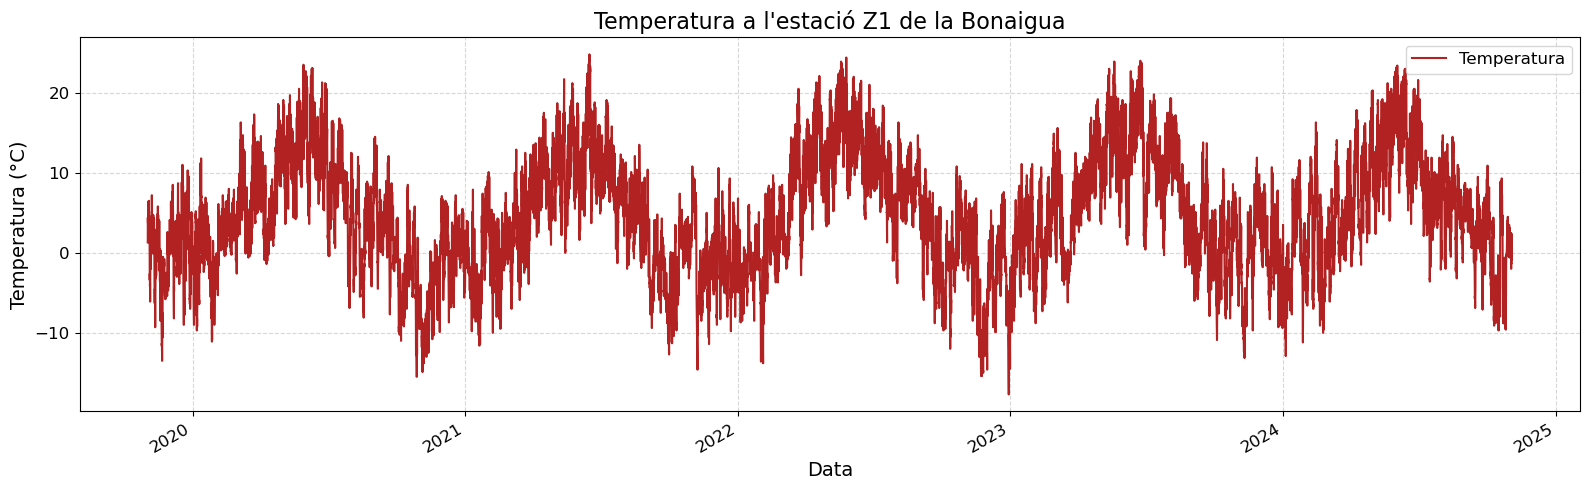

In [ ]:
plt.figure(figsize=(16, 5))
plt.plot(df_lstm['data'], df_lstm['valor'], label='Temperatura', color='firebrick', linewidth=1.5)

# Millores visuals
plt.title('Temperatura a l\'estació Z1 de la Bonaigua', fontsize=16)
plt.xlabel('Data', fontsize=14)
plt.ylabel('Temperatura (°C)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)

# Format de dates a l’eix X
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12))
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()

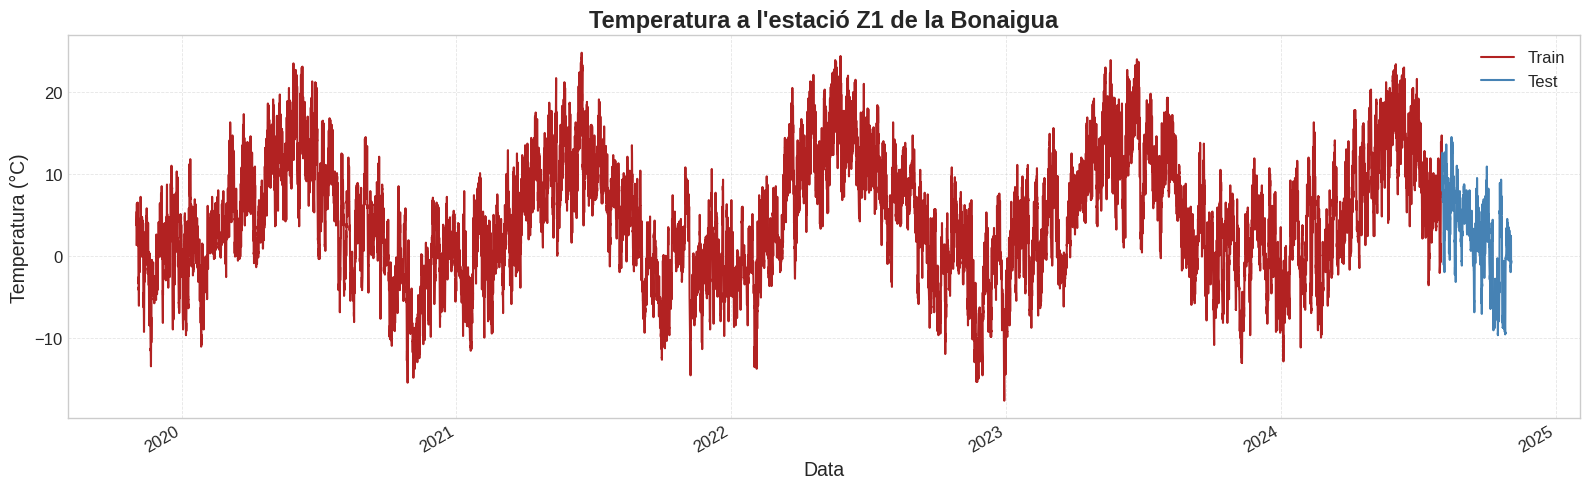

In [ ]:
# Separem train i test
# Train fins els últims 3 mesos del conjunt de dades
data_limit_train = df_lstm['data'].max() - pd.DateOffset(months=3)

df_train = df_lstm[df_lstm['data'] <= data_limit_train].copy()
df_test = df_lstm[df_lstm['data'] > data_limit_train].copy()


# Plot de les dades de train i test
plt.figure(figsize=(16, 5))

# Línies de train i test
plt.plot(df_train['data'], df_train['valor'], label='Train', color='firebrick', linewidth=1.5)
plt.plot(df_test['data'], df_test['valor'], label='Test', color='steelblue', linewidth=1.5)

# Estil igual que el que vols
plt.title('Temperatura a l\'estació Z1 de la Bonaigua', fontsize=17, weight='bold')  # 🔸 negreta
plt.xlabel('Data', fontsize=14)
plt.ylabel('Temperatura (°C)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5, linewidth=0.6)  # 🔸 graella suau
plt.legend(fontsize=12, frameon=False)  # 🔸 llegenda neta

# Format temporal de l’eix X
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12))
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()


In [ ]:
# Escalem la data

scaler = MinMaxScaler()

df_train['valor_scaled'] = scaler.fit_transform(df_train[['valor']])
df_test['valor_scaled'] = scaler.transform(df_test[['valor']])

In [42]:
df_train

,data,valor
186181,2020-01-01 00:00:00+00:00,0.45
186182,2020-01-01 01:00:00+00:00,0.45
186183,2020-01-01 02:00:00+00:00,0.49
186184,2020-01-01 03:00:00+00:00,0.52
186185,2020-01-01 04:00:00+00:00,0.51
...,...,...
227816,2024-09-30 19:00:00+00:00,0.65
227817,2024-09-30 20:00:00+00:00,0.64
227818,2024-09-30 21:00:00+00:00,0.62
227819,2024-09-30 22:00:00+00:00,0.61
